"""
 - 
"""

In [299]:
from utils import *
import sys, os, random

# two phones, ground floor, face level, 4 directions
datadir = "../data.upb/precis/02-precis-redmi-pixel4a"


In [ ]:
# code to patch into precalculate function to 
# initialize the c.ufingerprint['wifirssi'][mac] values to: 
# repeat the cross-validation step for every choice below 

#for f in c['fingerprints']:   # average across all directions (default)
#for f in c['fingerprints'][1:4:2]: # 13_180 
#    [0:1] # deirection 0 
#    for f in [c['fingerprints'][random.randint(0,3)]]: # random 
#       [0:3] # 3 dirs 
#    [0:2] # 2 dirs 
#    [::2] # 0 and 2 = 180
#    np.random.choice(range(0,4), size=2, replace=False)
    

In [296]:
import numpy as np
from scipy.spatial.distance import braycurtis
from scipy.stats import ks_2samp, chisquare
import copy 


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    rnddir = np.random.choice(range(0,4), size=2, replace=False)
    #for f in [c['fingerprints'][rnddir[0]], c['fingerprints'][rnddir[1]]]:
    for f in c['fingerprints']:    
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) 
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        #each fingerprint (direction) counts the same
        ufingerprint["wifirssi"][mac] = np.average(ufingerprint["wifirssi"][mac]) 
        
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
                #fingerprint["wifi"][mac]['rssi'] = []
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint


def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', verbose = False):
    # use processed fingerprints (all dirs, random dir, etc)
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # few APs in common -> similarity = 1
    if len(common_aps) < 0.5*len(wifi1.keys()):
        return 1.0
    rssi1 = np.empty(len(common_aps), dtype=float)
    rssi2 = np.empty(len(common_aps), dtype=float)
    
    if False: # how power is used in comparison 
        aps_only1 = list(set(wifi1.keys()).difference(set(wifi2.keys())))
        aps_only2 = list(set(wifi2.keys()).difference(set(wifi1.keys())))
        p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
        p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
        pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
        pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
        po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps_only1)))
        po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps_only2)))

        if verbose:
            print(f"common aps={len(common_aps)}")
            print(f"1={len(aps_only1)} 2={len(aps_only2)}")

            print(f"p1={np.mean(p1)} p2={np.mean(p2)}")
            print(f"pc1={np.mean(pc1)} pc2={np.mean(pc2)}")
            print(f"po1={np.mean(po1)} po2={np.mean(po2)}")

        # If not enough common APs -> similarity = 1
        if (po1 + 1.0 > pc1 and len(common_aps)*2  < len(aps_only1)) or \
            (po2 + 1.0 > pc2 and len(common_aps)*2 < len(aps_only2)): 
                return 1
   
    if selection == 'Bestdir':
        for ap in common_aps:
            for f1 in c1['fingerprints']: # all fingerprint dirs in the query 
                if not ap in f1['wifi'].keys():
                    continue
                m1 = np.average(f1['wifi'][ap]['rssi'])
                best = 100                
                for f2 in c2['fingerprints']: 
                    if not ap in f2['wifi'].keys():
                        continue
                    m2 = np.average(f2['wifi'][ap]['rssi'])
                    if(math.fabs(m2-m1)) < best:  # find one dir with closest RSSI
                        best = math.fabs(m2-m1)
                        bestf = m2
                rssi1.append(m1)
                rssi2.append(bestf)
                
        # Take only the first RSSI value                
    elif selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    elif selection == 'Average':
        nap = 0
        for ap in common_aps:
            #rssi1.append(np.average(adjust_rssi(wifi1[ap]['rssi'])))
            #rssi2.append(np.average(adjust_rssi(wifi2[ap]['rssi'])))
            rssi1[nap] = wifi1[ap] #np.average(wifi1[ap]['rssi'])
            rssi2[nap] = wifi2[ap] #np.average(wifi2[ap]['rssi'])
            nap = nap + 1

            #w.append(min(len(wifi1[ap]['rssi']), len(wifi2[ap]['rssi'])))

    elif selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(wifi1[ap]['rssi']))
            rssi2.append(np.median(wifi2[ap]['rssi']))

    elif selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(wifi1[ap]['rssi']))
            rssi2.append(np.mean(wifi2[ap]['rssi']))

    elif selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(wifi1[ap]['rssi']))
            rssi2.append(np.std(wifi2[ap]['rssi']))

    elif selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(wifi1[ap]['rssi']))
            rssi2.append(np.max(wifi2[ap]['rssi']))
            
    elif selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    elif selection == 'Tempered':
        for ap in common_aps:
            rss_1.append(np.average(rssi_v[index][key]) * random.uniform(0.8, 1.2))
            rss_2.append(np.average(rssi_v[r][key]) * random.uniform(0.8, 1.2))
           
    if selection != 'KS':
        mdif = np.mean(np.array(rssi2)-np.array(rssi1))

    if verbose:
        print("rssi1=", *rssi1, sep=", ")
        print("rssi2=", *rssi2, sep = ", ")
    
    #return simil_method(np.diff(adjust_rssi(rssi1)), np.diff(adjust_rssi(rssi2)))
    return simil_method(adjust_rssi(rssi1), adjust_rssi(rssi2))
    

In [149]:
etaje_fnames = [
"0-pixel-04-06-2021_19-34-41.json", 
"0-redmi-04-06-2021_19-33-47.json"
]
 
etaje = []
for e in etaje_fnames: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    etaje.append(etaj)
    

In [83]:
def set_of_aps_col(c):
    #aps = set([])
    #for f in c['fingerprints']:
    #    aps = aps.union(set(f['wifi'].keys()))
    return set().union(*(f['wifi'].keys() for f in c['fingerprints']))

def set_of_aps_floor(e):
    return set().union(* (set_of_aps_col(c) for c in e))
    


aps0 = set_of_aps_floor(etaje[0])
aps1 = set_of_aps_floor(etaje[1])

print(len(aps0-aps1), len(aps1-aps0), len(aps0&aps1))
print(set_of_aps_col(etaje[0][1]).issubset(aps1))

2 4 79
True


In [86]:
#grid structure contains list of points for each square of size 10(gridsize) 
# for a point x,y in grid[x/10][y/10] its neighbors are in 8-neighborhood 
# at most 10m away 
e = 0
gridsize = 10 # 10 meter grid
maxx = -10000
maxy = -10000
for c in etaje[e]:
    if c['x'] > maxx:
        maxx = c['x']
    if c['y'] > maxy:
        maxy = c['y']
    
# allocate 1 extra row column so that we test 8-neighborhood    
grid = [] 
for r in range(0, 2 + int(maxx/gridsize)):
    grid.append([[]] * (2 + int(maxy/gridsize)))

for gx in range(0, 2 + int(maxx/gridsize)):
    for gy in range(0, 2 + int(maxy/gridsize)):
        grid[gx][gy] = [] # Python love is beginning to fade

maxgsize = 0     
sumgsize = 0 
for c in range(0, len(etaje[e])):
    gx = int(etaje[e][c]['x'] / gridsize ) # my grid
    gy = int(etaje[e][c]['y'] / gridsize )
    grid[gx][gy].append(c) # grid[gx][gy] is an index in etaj[e][]
    #print(type(grid[gx][gy]), type(len(grid[gx][gy])), type(maxgsize))
    if len(grid[gx][gy]) > maxgsize:
        maxgsize = len(grid[gx][gy])
    sumgsize = sumgsize + len(grid[gx][gy])    

print(f"maxx={maxx:.1f}, maxy={maxy:.1f} maxgridlen={maxgsize} avggridlen={sumgsize/len(etaje[e]):.2f}")


maxx=54.4, maxy=33.2 maxgridlen=30 avggridlen=12.01


In [87]:
# precompute list of nearby points, < 10.0 meters 
# for point i in etaj e, nbrs[i] contain a list of indices of points  

before = datetime.datetime.now()
e = 0
npct = len(etaje[e])
nbrs = [] 
nnbrs = 0 
for q in np.arange(0, npct): 
    
    gx = int(etaje[e][q]['x'] / gridsize ) # my grid
    gy = int(etaje[e][q]['y'] / gridsize )
    nbrsq = []
    
    for gi in range(gx-1,gx+2):
        for gj in range(gy-1,gy+2):
            for p in grid[gi][gj]:
                if p == q: 
                    continue 
                eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                        [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
                # we hope not to have 10m errors- if yes, increase  this value and rerun
                if eu_dist < 10.0: 
                    nbrsq.append(p)
    nbrs.append(nbrsq)
    nnbrs = nnbrs + len(nbrsq)
after = datetime.datetime.now()
print(f"{len(nbrs)} points, {nnbrs/len(nbrs):.1f} neighbors on average;  in {(after-before).seconds} seconds")
#print(nbrs)

84 points, 39.2 neighbors on average;  in 0 seconds


In [255]:
# 
# assumes query_cols(length q) and db_cols(length d) are preprocessed 
# returns list of indexq, indexp, eu_dist, disimilarity 
def cross_validation(query_cols, db_cols):
    before = datetime.datetime.now()
    allpairs = []
    best_d = []
    for q in range(0, len(query_cols), 1): 
        mindisim = 1
        mindist = 100
        for p in range(0, len(db_cols), 1):
            eu_dist = euclidean([query_cols[q]['x'], query_cols[q]['y'], query_cols[q]['z']], 
                                    [db_cols[p]['x'], db_cols[p]['y'], db_cols[p]['z']]) 
            if(eu_dist > 10.0):
                continue
            disim = compare_locations(query_cols[q], db_cols[p], selection = 'Average')
            allpairs.append([ q, p, eu_dist, disim])
            if disim < mindisim:
                mindisim = disim
                mindist = eu_dist
        best_d.append(mindist)  # keep the euclidean distance for the smallest disimilarity       
    after = datetime.datetime.now()
    print(f"{len(allpairs)} pairs in {(after-before).seconds:.2f} seconds")
    return best_d, allpairs 



In [297]:
for e in etaje: 
    for c in etaj:
        precalculate(c) # col['ufingerprint']['wifirssi'][mac] = dBm 

pixel_redmi = cross_validation(etaje[0], etaje[1])
redmi_pixel = cross_validation(etaje[1], etaje[0])
        
        

3419 pairs in 2.00 seconds
3419 pairs in 2.00 seconds


In [298]:
print(np.percentile(pixel_redmi[0], [50, 95]))
print(np.percentile(redmi_pixel[0], [50, 95]))

[0.922593   2.76385248]
[0.86345006 2.52212691]


In [290]:
print(np.percentile(pixel_redmi[0], [50, 95]))
print(np.percentile(redmi_pixel[0], [50, 95]))


[0.95511659 2.69696803]
[0.81111343 2.11409205]


0.0 9.996116045744966 2000
0.0717846381878661 0.6336667608156413 2000


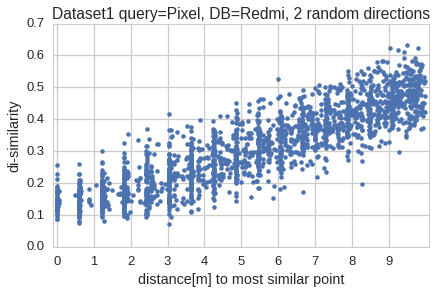

In [267]:
#print(pixel_redmi[1])
eu = [r[2] for r in pixel_redmi[1][0:2000]]
di = [r[3] for r in pixel_redmi[1][0:2000]]

print(np.min(eu), np.max(eu), len(eu))
print(np.min(di), np.max(di), len(di))

plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(eu, di, ".", label='bestdir')
   
plt.xlabel('distance[m] to most similar point')
plt.ylabel('di-similarity')
plt.grid(True)
plt.title(f"Dataset1 query=Pixel, DB=Redmi, 2 random directions")
plt.xticks(range(0, 10))
plt.yticks(np.arange(-0.1, 1, 0.1))
ax.set_ylim(0, 0.7)
ax.set_xlim(-0.1, 10.1)
#plt.legend(loc="upper right",shadow=True, fancybox=True)
plt.show()
fig.savefig(f"Braycurtis_vs_dist_precis_rnd2dir.pdf", bbox_inches='tight')

In [221]:
#errs2_180= minra
#errs_all= minra
#errs2_90= minra
#errs3= minra
#errs_rand= minra
#errs_0= minra
#errs_13_180 = minra
#errs_rand2 = minra
ticks=["all 4 dir", "dir 0", "dir 0,2", "dir 1,3", "dir 0,1", \
       "dir 0-2", "rnd", "rnd 2"]
for d, err in zip(ticks, [errs_all, errs_0, errs2_180, errs_13_180, errs2_90, errs3, errs_rand, \
                      errs_rand2 ]):
    p = np.percentile(err, [50, 95])
    print(f"Direction:{d} errors 50/95% {p[0]:.2f}m/{p[1]:.1f}m")

Direction:all 4 dir errors 50/95% 0.65m/2.2m
Direction:dir 0 errors 50/95% 0.64m/2.8m
Direction:dir 0,2 errors 50/95% 0.79m/2.5m
Direction:dir 1,3 errors 50/95% 0.61m/2.2m
Direction:dir 0,1 errors 50/95% 0.64m/2.4m
Direction:dir 0-2 errors 50/95% 0.65m/2.2m
Direction:rnd errors 50/95% 1.82m/5.1m
Direction:rnd 2 errors 50/95% 0.65m/2.5m


#err data was run successively 
Direction:all 4 dir errors 50/95% 0.65m/2.2m
Direction:dir 0 errors 50/95% 0.64m/2.8m
Direction:dir 0,2 errors 50/95% 0.79m/2.5m
Direction:dir 1,3 errors 50/95% 0.61m/2.2m
Direction:dir 0,1 errors 50/95% 0.64m/2.4m
Direction:dir 0-2 errors 50/95% 0.65m/2.2m
Direction:rnd errors 50/95% 1.82m/5.1m
Direction:rnd 2 errors 50/95% 0.65m/2.5m

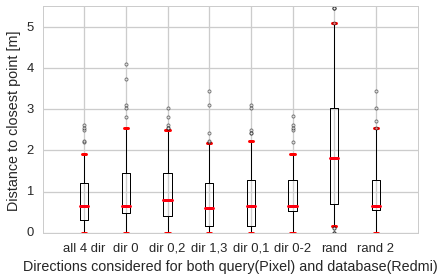

In [271]:
# bd = (query, p , dist , disim)

fig1, ax1 = plt.subplots(figsize=(6, 4))
ticks=["all 4 dir", "dir 0", "dir 0,2", "dir 1,3", "dir 0,1", \
       "dir 0-2", "rand", "rand 2"]
bp = ax1.boxplot([errs_all, errs_0, errs2_180, errs_13_180, errs2_90, errs3, errs_rand, \
                      errs_rand2 ],  
                     positions=np.array(range(len(ticks)))*2, 
                     whis=(5,95),
                     widths=0.4)

ax1.set_xticks(range(0, len(ticks) * 2, 2))
ax1.set_yticks(np.arange(0, 5.5, 0.5), minor=True)
ax1.set_xticklabels(ticks)
ax1.set_xlim(-2, len(ticks)*2)
ax1.set_ylim(0, 5.5)
ax1.set_xlabel("Directions considered for both query(Pixel) and database(Redmi)")
ax1.set_ylabel("Distance to closest point [m]")
plt.setp(bp['boxes'], color='k')
plt.setp(bp['whiskers'], color='k', linestyle='-')
plt.setp(bp['caps'], color='r', linewidth=3)
plt.setp(bp["fliers"], markeredgecolor='k', marker='o', markersize=3.0, alpha=0.5)
plt.setp(bp['medians'], color='#ff0011', linewidth=3)
fig1.tight_layout()
plt.show()
fig1.savefig("Measurement_methods_facelevel_precis0.pdf", bbox_inches='tight')


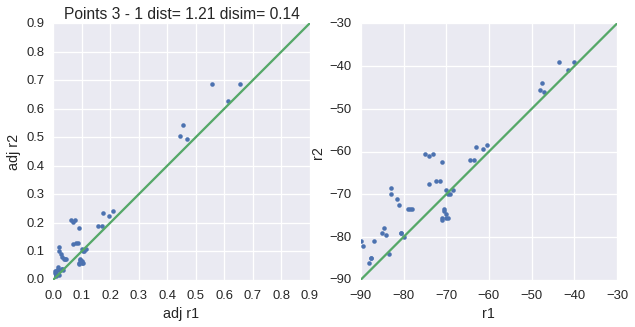

(0.14414143205676358, 0.17363020543272079, 0.3843903492120525, 1.211000000000002)


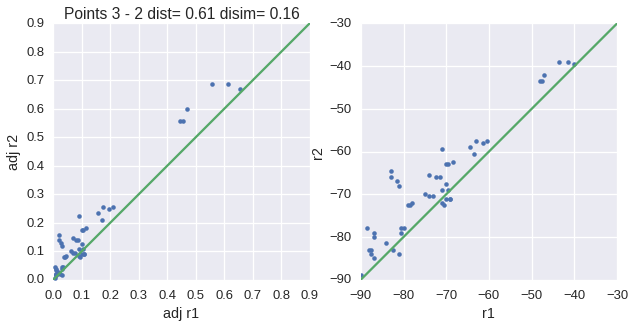

(0.16094819483304823, 0.19226245921648952, 0.4376733646182578, 0.6060000000000016)
(0.18559507339800205, 0.16509694174938785, 0.5822024043997236, 0.6059999999999981)


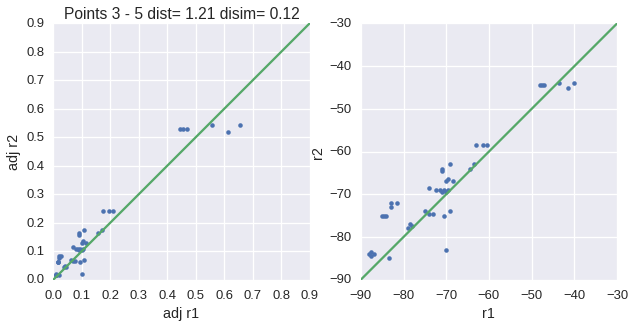

(0.11855082905965134, 0.17399107065433914, 0.30199937710503927, 1.2119999999999997)


In [246]:

def compare_points(p1, p2, graph = False):
    c1 = etaje[0][p1]
    c2 = etaje[1][p2]

    common_aps = list(set(c1['ufingerprint']['wifirssi'].keys()) & set(c2['ufingerprint']['wifirssi'].keys()))
    r1 = [c1['ufingerprint']['wifirssi'][x] for x in common_aps]
    r2 = [c2['ufingerprint']['wifirssi'][x] for x in common_aps]

    bc =  braycurtis(adjust_rssi(r1), adjust_rssi(r2))
    meddif = np.sqrt(np.median(np.abs(np.array(adjust_rssi(r1)) - np.array(adjust_rssi(r2)))))
    eu_ss = np.sqrt(np.sum(np.square(np.array(adjust_rssi(r1)) - np.array(adjust_rssi(r2)))))
    eu_dist = euclidean([c1['x'], c1['y'], c1['z']], 
                                [c2['x'], c2['y'], c2['z']]) 

    if graph:
        fig =  plt.figure(figsize=(9, 6))     
        ax = plt.subplot(1, 2, 1)
        ax.set_aspect('equal')
        plt.plot(adjust_rssi(r1), adjust_rssi(r2), ".", label='bestdir')
        plt.plot([-0,0.9], [-0,0.9], "-")
        plt.xlabel('adj r1')
        plt.ylabel('adj r2')
        plt.grid(True)
        plt.title(f"Points {p1} - {p2} dist= {eu_dist:.2f} disim= {bc:.2f}" )
        #plt.xticks(range(-90, -30, 5))
        #plt.yticks(range(-90, -30, 5))
        #plt.legend(loc="upper right",shadow=True, fancybox=True)
        #plt.show()


        
        ax = plt.subplot(1, 2, 2)
        ax.set_aspect('equal')
        plt.plot(r1, r2, ".", label='')
        plt.plot([-90,-30], [-90,-30], "-")
        plt.xlabel('r1')
        plt.ylabel('r2')
        plt.grid(True)
        #plt.title(f"Floor={e} points={npct} pairs={len(bd)}")
        #plt.xticks(range(-90, -30, 5))
        #plt.yticks(range(-90, -30, 5))
        #plt.legend(loc="upper right",shadow=True, fancybox=True)
        plt.show()

    #print("disim = ", braycurtis(adjust_rssi(r1), adjust_rssi(r2)))
    #print("median diff = ", np.sqrt(np.median(np.abs(np.array(adjust_rssi(r1)) - np.array(adjust_rssi(r2))))))
    #print("eu = ", np.sqrt(np.sum(np.square(np.array(adjust_rssi(r1)) - np.array(adjust_rssi(r2))))))
    
    return (bc, meddif, eu_ss, eu_dist)

e = 0
print(compare_points(3, 1, True))
print(compare_points(3, 2, True))
print(compare_points(3, 4, False))
print(compare_points(3, 5, True))



